## Importing necessary libraries

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,RNN,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pickle
import nltk.translate.bleu_score as bleu
import shutil
from IPython.display import Image

In [1]:
#!wget --header="Host: doc-04-2g-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_p1fg4b07u3raciih5atnsbt7sdk7uaqn_nonce=gip6alipm66no" --header="Connection: keep-alive" "https://doc-04-2g-docs.googleusercontent.com/docs/securesc/k57aefr9gh8rpf3r9srcg2pseasqmf46/as2krtvlbds6mgrr388kcpm3uhv0kvbu/1617009675000/04473764286494136551/04473764286494136551/1e2pbLAHxvP2m41eVPH8ZJL-wqfTGNiKd?e=download&authuser=0&nonce=gip6alipm66no&user=04473764286494136551&hash=6pbo31i4v1ujdid1e1vmr39u6gvhf3il" -c -O 'gec_enc_dec.zip'
#!unzip 'gec_enc_dec.zip'

## Making data model ready

In [2]:
train = pd.read_csv("train_word.csv")
cv = pd.read_csv("cv_word.csv")
test = pd.read_csv("test_word.csv")

We will add <"start"> to each sentence which will be input to decoder
We will add <"end"> to each sentence which will be outpuof decoder

In [3]:
train["correct_inp"] = "<start> " + train["correct"].astype(str)
train["correct_out"] = train["correct"].astype(str) + " <end>"

cv["correct_inp"] = "<start> " + cv["correct"].astype(str)
cv["correct_out"] = cv["correct"].astype(str) + " <end>"

test["correct_inp"] = "<start> " + test["correct"].astype(str)
test["correct_out"] = test["correct"].astype(str) + " <end>"

In [4]:
# code reference https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring
# loading saved tokenizer
with open("tokenizer_incorr_word.pickle","rb") as temp1:
    tokenizer_incorr = pickle.load(temp1)
    
with open("tokenizer_corr_inp_word.pickle","rb") as temp2:
    tokenizer_corr_inp = pickle.load(temp2)
    
with open("tokenizer_corr_out_word.pickle","rb") as temp3:
    tokenizer_corr_out = pickle.load(temp3)

Tokenizing senetence for feeding to encoder

In [5]:
#tokenizer_incorr = Tokenizer(filters="",lower=False)
#tokenizer_incorr.fit_on_texts(train["incorrect"].values)

incorr_train = np.array(tokenizer_incorr.texts_to_sequences(train["incorrect"].values))
incorr_cv = np.array(tokenizer_incorr.texts_to_sequences(cv["incorrect"].values))
#incorr_test = np.array(tokenizer_incorr.texts_to_sequences(test["incorrect"].values))
#print("vocab size of incorrrect sentences is",len(tokenizer_incorr.word_index))

vocab size of incorrrect sentences is 85250


Tokenizing senetence for feeding to decoder as inpput

In [6]:
#tokenizer_corr_inp = Tokenizer(filters="",lower=False)
#tokenizer_corr_inp.fit_on_texts(train["correct_inp"].values)

corr_train_inp = np.array(tokenizer_corr_inp.texts_to_sequences(train["correct_inp"].values))
corr_cv_inp = np.array(tokenizer_corr_inp.texts_to_sequences(cv["correct_inp"].values))
#corr_test_inp = np.array(tokenizer_corr_inp.texts_to_sequences(test["correct_inp"].values))
#print("vocab size of corrrect sentences is",len(tokenizer_corr_inp.word_index))

Tokenizing senetence which will be output of decoder

In [7]:
#tokenizer_corr_out = Tokenizer(filters="",lower=False)
#tokenizer_corr_out.fit_on_texts(train["correct_out"].values)

corr_train_out = np.array(tokenizer_corr_out.texts_to_sequences(train["correct_out"].values))
corr_cv_out = np.array(tokenizer_corr_out.texts_to_sequences(cv["correct_out"].values))
#corr_test_out = np.array(tokenizer_corr_out.texts_to_sequences(test["correct_out"].values))
#print("vocab size of corrrect sentences is",len(tokenizer_corr_out.word_index))

In [8]:
# #save keras tokenizer

# with open("tokenizer_incorr_word.pickle","wb") as temp1:
#     pickle.dump(tokenizer_incorr,temp1)
    
# with open("tokenizer_corr_inp_word.pickle","wb") as temp2:
#     pickle.dump(tokenizer_corr_inp,temp2)
    
# with open("tokenizer_corr_out_word.pickle","wb") as temp3:
#     pickle.dump(tokenizer_corr_out,temp3)

Padding train, cv, test data

In [8]:
incorr_train = np.array(pad_sequences(incorr_train,maxlen=25,padding="post",truncating='post'))
corr_train_inp = np.array(pad_sequences(corr_train_inp,maxlen=25,padding="post",truncating='post'))
corr_train_out = np.array(pad_sequences(corr_train_out,maxlen=25,padding="post",truncating='post'))

incorr_cv = np.array(pad_sequences(incorr_cv,maxlen=25,padding="post",truncating='post'))
corr_cv_inp = np.array(pad_sequences(corr_cv_inp,maxlen=25,padding="post",truncating='post'))
corr_cv_out = np.array(pad_sequences(corr_cv_out,maxlen=25,padding="post",truncating='post'))

#### Defining model artchitecture

In [9]:
# code taken from attention mechanism assignment

############################## Encoder class #############################################################

class Encoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        
        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
                           mask_zero=True,name="embedding_layer_encoder")
        self.lstmcell = tf.keras.layers.LSTMCell(lstm_size)
        self.encoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)


    def call(self,input_sequence,states):

        output1 = self.embedding(input_sequence)
        enco_output, enco_state_h, enco_state_c = self.encoder_lstm(output1, initial_state=states)
        return enco_output, enco_state_h, enco_state_c

    
    def initialize_states(self,batch_size):

        initial_hidden_state = tf.zeros([batch_size,self.lstm_size])
        initial_cell_state = tf.zeros([batch_size,self.lstm_size])
        
        return [initial_hidden_state,initial_cell_state]
    
############################## Decoder class #############################################################
    
class Decoder(tf.keras.layers.Layer):

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):

        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(input_dim=out_vocab_size, output_dim=embedding_size, input_length=input_length,
                           mask_zero=True,name="embedding_layer_encoder")
        self.lstmcell = tf.keras.layers.LSTMCell(lstm_size)
        self.decoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)

    def call(self,target_sequence,initial_states):

        output2 = self.embedding(target_sequence)
        deco_output, deco_state_h, deco_state_c = self.decoder_lstm(output2, initial_state=initial_states)
      
        return deco_output, deco_state_h, deco_state_c
    
##############################encoder decoder class#############################################################
    
qw_state = 0
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,inp_vocab_size,out_vocab_size,embedding_size,lstm_size,input_length,batch_size,*args):
        
        super().__init__()
        self.encoder = Encoder(inp_vocab_size,embedding_size,lstm_size,input_length)
        #print("output vocab size in encoder decoder class",out_vocab_size)
        self.decoder = Decoder(out_vocab_size,embedding_size,lstm_size,input_length)
        self.dense   = Dense(out_vocab_size)#, activation='softmax')
        self.batch = batch_size
    
    
    def call(self,data,*args):
        
        input,output = data[0], data[1]
        # initializing initial states of encoder
        l = self.encoder.initialize_states(self.batch)
        qw_state = l
        encoder_output,encoder_final_state_h,encoder_final_state_c = self.encoder(input,l)
        m = list((encoder_final_state_h,encoder_final_state_c))
        decoder_output,decoder_final_state_h,decoder_final_state_c = self.decoder(output,m)
        qw_output = self.dense(decoder_output)
        #print("FINAL OUTPUT SHAPE",qw_output.shape)
        return qw_output

In [10]:
inp_vocab_size = 85251
out_vocab_size = 66430
embedding_dim=25
input_length=25
lstm_size=64
batch_size=256
#model = Encoder_decoder(inp_vocab_size,out_vocab_size,embedding_dim,lstm_size,input_length,batch_size)

optimizer = tf.keras.optimizers.Adam()
#defining custom loss function which will not consider loss for padded zeroes
# code taken from attention assignment
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
#model.compile(optimizer=optimizer,loss=loss_function)

In [ ]:
#Load the TensorBoard notebook extension
import datetime
%load_ext tensorboard
!rm -rf ./logs/

Train the model

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(x=[incorr_train,corr_train_inp],y=corr_train_out, epochs=10,batch_size=256,callbacks=[tensorboard_callback],validation_data=([incorr_train_cv,corr_cv_inp],corr_cv_out))

Epoch 1/10
1664/1664 [==============================] - 667s 399ms/step - loss: 1.7666 - val_loss: 1.2702
Epoch 2/10
1664/1664 [==============================] - 660s 397ms/step - loss: 1.2786 - val_loss: 1.0721
Epoch 3/10
1664/1664 [==============================] - 662s 398ms/step - loss: 1.0958 - val_loss: 0.9640
Epoch 4/10
1664/1664 [==============================] - 662s 398ms/step - loss: 0.9923 - val_loss: 0.8989
Epoch 5/10
1664/1664 [==============================] - 663s 399ms/step - loss: 0.9280 - val_loss: 0.8560
Epoch 6/10
1664/1664 [==============================] - 662s 398ms/step - loss: 0.8784 - val_loss: 0.8252
Epoch 7/10
1664/1664 [==============================] - 661s 397ms/step - loss: 0.8370 - val_loss: 0.8005
Epoch 8/10
1664/1664 [==============================] - 662s 398ms/step - loss: 0.8056 - val_loss: 0.7785
Epoch 9/10
1664/1664 [==============================] - 663s 398ms/step - loss: 0.7804 - val_loss: 0.7624
Epoch 10/10
1664/1664 [=======================

In [ ]:
#%tensorboard --logdir logs/fit

In [11]:
# code taken from https://colab.research.google.com/drive/172D4jishSgE3N7AO6U2OKAA_0wNnrMOq#scrollTo=mJqOn0snzCRy
#model.save_weights('enco_dec_word', save_format='tf')

# relaod saved model
model = Encoder_decoder(inp_vocab_size,out_vocab_size,embedding_dim,lstm_size,input_length,batch_size)
model.compile(optimizer=optimizer,loss=loss_function)
model.train_on_batch([incorr_train[:256],corr_train_inp[:256]],corr_train_out[:256])
model.load_weights('enco_dec_word')

In [13]:
model.summary()

Model: "encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  2154315   
_________________________________________________________________
decoder (Decoder)            multiple                  1683790   
_________________________________________________________________
dense (Dense)                multiple                  4317950   
Total params: 8,156,055
Trainable params: 8,156,055
Non-trainable params: 0
_________________________________________________________________


Defining predict function

In [14]:
#code taken from attention mechanism assignment
corr_dict = tokenizer_corr_out.word_index
inv_corr = {v: k for k, v in corr_dict.items()}

def predict(input_sentence):
    """
    this function takes incorrect input sentences s input and retirns correct sentences
    """
    input_sentence = tokenizer_incorr.texts_to_sequences([input_sentence])
    initial_hidden_state = tf.zeros([1,64])
    initial_cell_state = tf.zeros([1,64])
    qwst = [initial_hidden_state,initial_cell_state]
    pred_total = []
    enc_output, enc_state_h, enc_state_c = model.layers[0](np.expand_dims(input_sentence[0],0),qwst)
    states_values = [enc_state_h, enc_state_c]
    pred = []
    sentence = []
    cur_vec = np.array([[1]])
    for i in range(40):
        dec_output, dec_state_h, dec_state_c = model.layers[1](cur_vec,states_values)
        infe_output=model.layers[2](dec_output)
        states_values = [dec_state_h, dec_state_c]
        cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
        if inv_corr[cur_vec[0][0]] == '<end>':
            break
        pred.append(cur_vec[0][0])
    for i in pred:
        sentence.append(inv_corr[i])
    return " ".join(sentence)

#### GLUE Score on test data

In [17]:
from nltk.translate.gleu_score import sentence_gleu

gleu_score_test = 0
length = 100

for i in range(length):
    reference = [test["correct"].values[i:i+1][0].split()]
    candidate = predict(test["incorrect"].values[i:i+1][0]).split()
    gleu_score_test = gleu_score_test + sentence_gleu(reference, candidate)
print("Final GLEU Score on Test data are",gleu_score_test/length)

Final GLEU Score on Test data are 0.17559579785965793


#### Prediting results on train data

In [ ]:
#predicted sentences for 10 sentences
for i in train["incorrect"].values[:10]:
  print(predict(i))

I am writing a good friend , and I will try to write a new word and love to see .
So I 've been looking forward to seeing them , but I will go there .
BTW like the most of the cherry blossoms are sold out to the local people and we have to cook for a lot of food .
Asakusa is a game of the famous place , and eat Japanese food , and it will be in the next stage .
After watching the movie , my English and I like to do a lot of people .
I think my name is about their products .
My friend was going to my wife and it was a crazy !
Today I received a letter from Lang , which is one of you .
I know that the power is not .
So I did n't know that we can eat any new places in Japan .


In [ ]:
#actual sentences for 10 sentences
train["correct"].values[:10]

array(['I signed up on Lang   because I want to improve my English and I want learn Spanish .',
       "So I ended up buying stuff I did ' nt expect to buy .",
       'Penguins like big places for their environment , so the Zoo uses big mirrors as walls to make them feel more comfortable .',
       ' MINI STOP  is one of the popular convenience stores in Japan and sells several delicious ice creams .',
       'After watching the video and listening to the song , I became more interested .',
       'I think my strengths aresuitable for theMarketing field .',
       'My dog and I went to see my mom off  !',
       'Today I received a message from one of my Lang   friends .',
       'I know that radioactivity is dangerous .',
       'So , I wonder if there are surprising things eaten or so in your country .'],
      dtype=object)

#### Prediting results on cv data

In [ ]:
#predicted sentences for 10 sentences
for i in cv["incorrect"].values[:10]:
  print(predict(i))

It will be in the way to know , but the way is to be a special way , so I was too .
Although I was all young people in many other countries , I have a lot of Tokyo .
A birthday and a lot of the House
One is not easy to learn how to learn people .
They are a Japanese person who is a few different from the company .
Of course , I want to go to school , but I have a lot of English .
It is difficult to understand how to do something I can help my friends . . .
I usually go to the house for the two of the school .
I had a lot of days .
Hello ! Hello , my first diary is trying to write about me .


In [ ]:
#actual sentences
cv["correct"].values[:10]

array(['There should be some other patterns of tying the Obi , but I think the easiest one is used nowadays .',
       'Although I expected there would be many children in the museum , actually almost all of the visitors were adults .',
       'Golden Retriever and Kai Ken ',
       'One who is not willing to learn is not worth learning anything .',
       'They are people who have different majors from different hometowns .',
       'Of course , I wanted to enter graduate school but I could not .',
       "It is hard to say some words , especially to someone who does n't want to listen to you . . .",
       'I usually leave for work at  :  a . m .',
       'I had a stomach ache fora few days .',
       'Hello ! This is my first time writing on Lang   , so I will introduce myself .'],
      dtype=object)

#### Prediting results on test data

In [ ]:
#predicted sentences for 10 sentences
for i in test["incorrect"].values[:10]:
  print(predict(i))

And the news of the other people were working for a very good ?
But I 'll try to take a TOEIC test today .
If you have a Chinese , you can go to the U 's in America .
The office is a new room .
The food of food , eat food with a lot of the health .
After all it is a bad way to do it .
Maybe it 's like my best time , I could n't make a lot of friends .
It was very bad , so I had to be a big time to stop the car of us to the ground .
It will be fine tomorrow .
A few , but , I do n't correct the world .


In [ ]:
#actual sentences for 10 sentences
test["correct"].values[:10]

array(['And the lecturer told the students that they were expected to use their',
       'But I had to take the TOEIC today .',
       'If you so , please go Kitchen yorozuya in Aichi pref .',
       'The office is locked on weekends .',
       'Other small dishes tasted like soup had been soaked into them .',
       'After all these are hard times .',
       "Maybe it 's because of this reason that I love making friends like my father .",
       'It was dim because of the bad lighting , so it was hard work for us to see the merchandise .',
       'The weather will be fine tomorrow .',
       "A wise saying , which apparently I 'm not following at all ."],
      dtype=object)

#### Plotting tensorboard plots

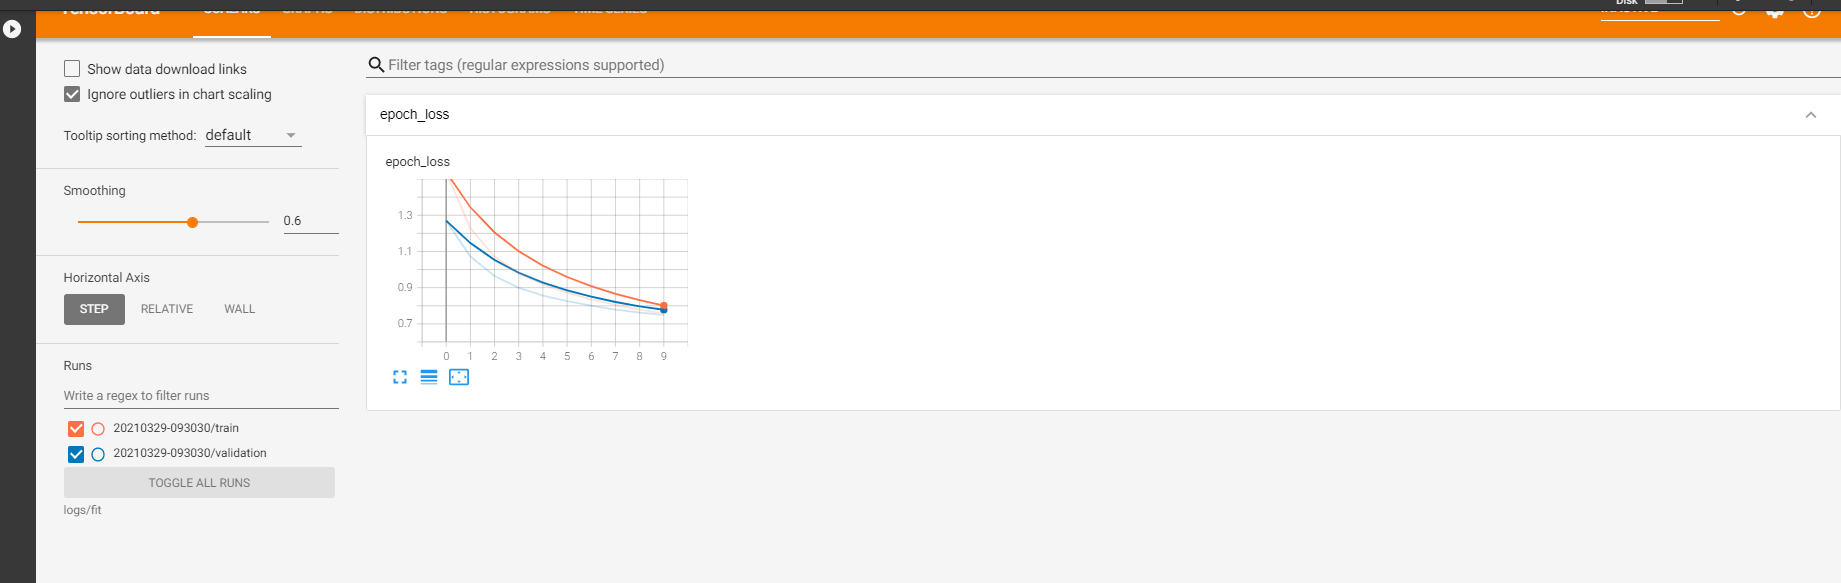

In [24]:
Image(filename='encoder_decoder_word_1.png')

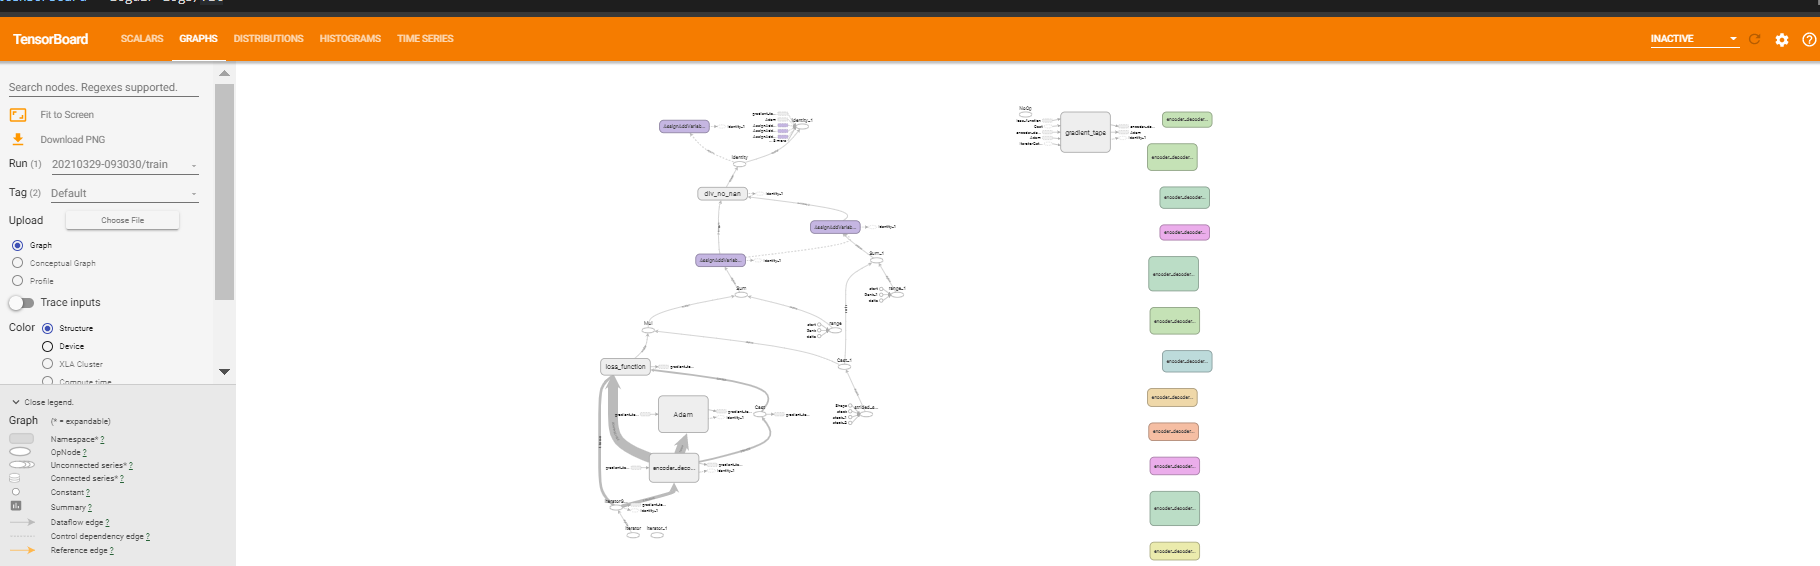

In [25]:
Image(filename='encoder_decoder_word_2.png')

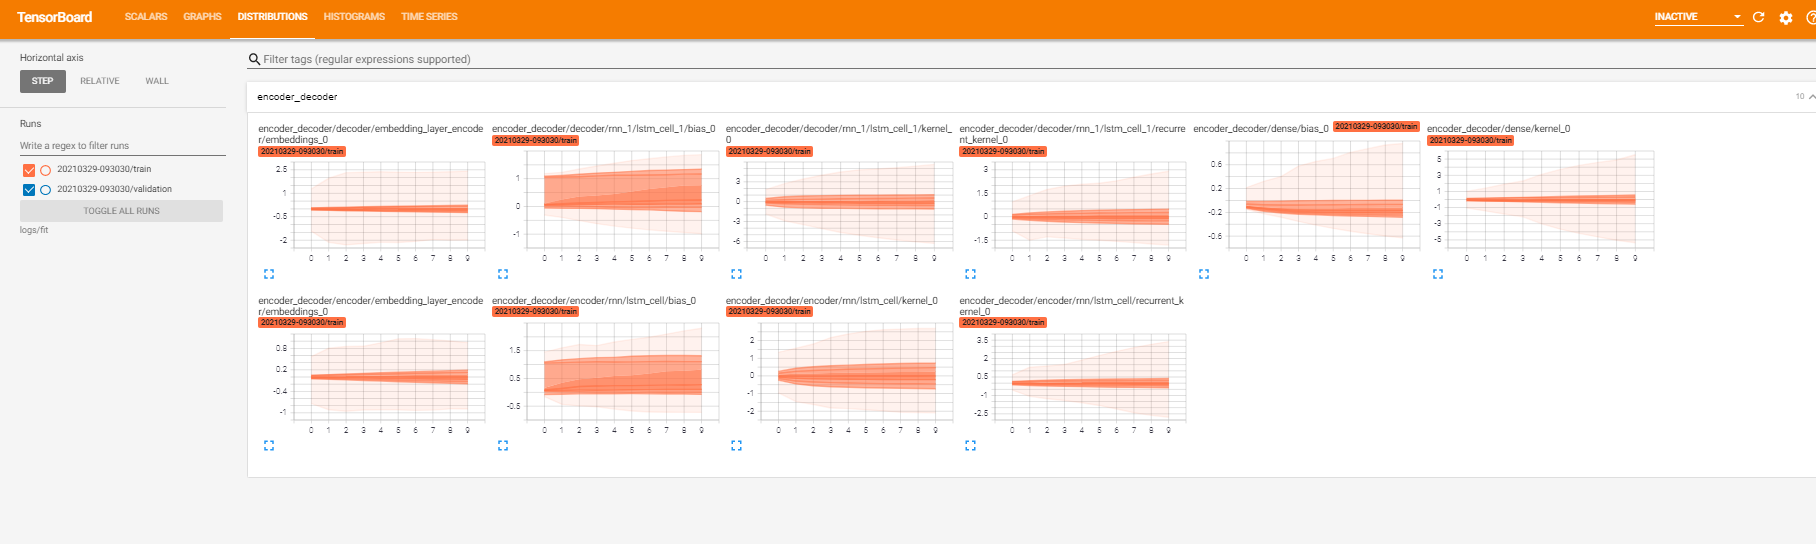

In [26]:
Image(filename='encoder_decoder_word_3.png')

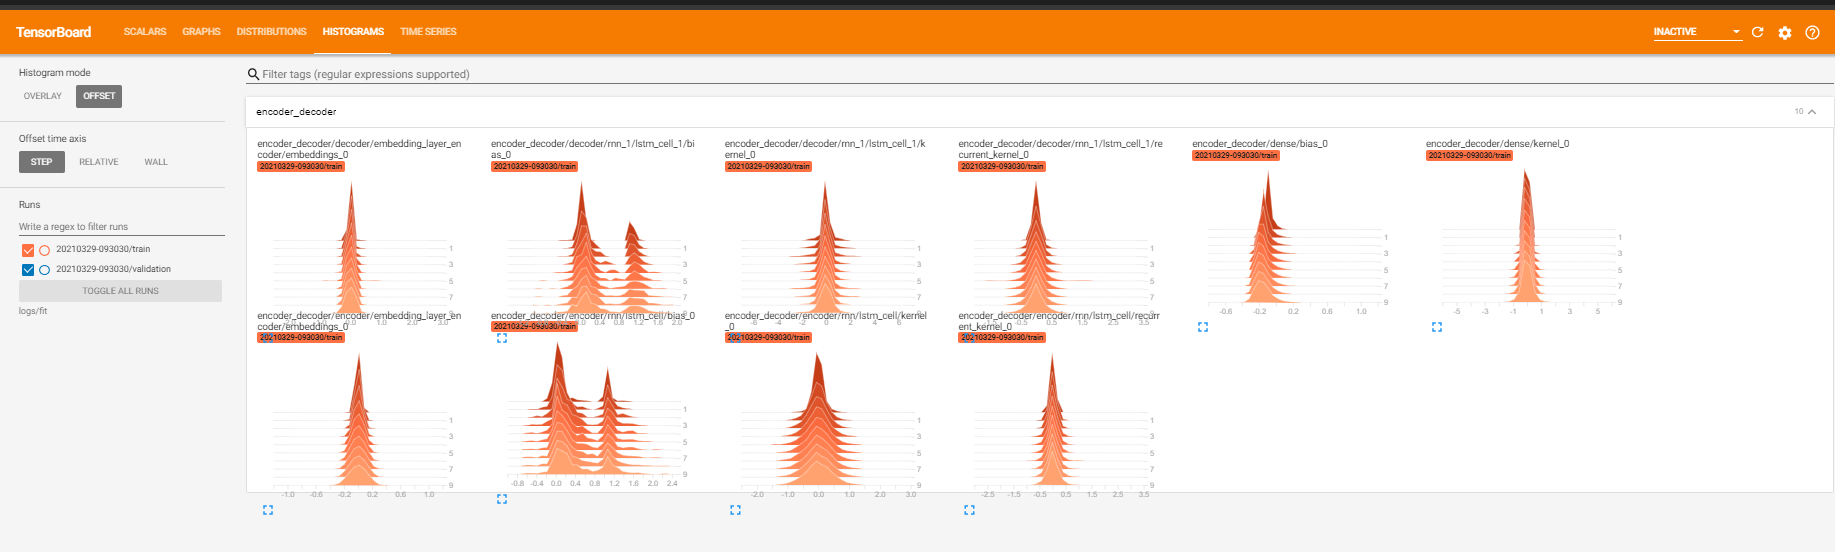

In [27]:
Image(filename='encoder_decoder_word_4.png')